In [1]:
import sys
sys.path.append("../..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Jupyter stuff
# You may need to conda install seaborn matplotlib tqdm jupyterlab
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [4]:
import random
import numpy as np
from statistics import median

from tangle.core import Tangle, Transaction
from tangle.core.tip_selection import MaxDepthTipSelector, AccuracyTipSelector
from tangle.core.tip_selection.accuracy_tip_selector import AccuracyTipSelectorSettings
from tangle.theory import TempTransactionStore, TheoreticalNode


In [5]:
NUM_NODES = 1000
NUM_ROUNDS = 50
VALIDATIONS_PER_ROUND = 10

DIST_STD_DEV = 100
CLUSTER_DISTANCE = 500
clusters = [
    [0, 0],
    [0, 500],
    [500, 0],
    [500, 500],
]
NUM_CLUSTERS = len(clusters)
NODES_PER_ROUND = 5 * NUM_CLUSTERS

In [6]:
tip_selection_settings = {}
tip_selection_settings[AccuracyTipSelectorSettings.SELECTION_STRATEGY]  = "WALK"
tip_selection_settings[AccuracyTipSelectorSettings.CUMULATE_RATINGS]    = False
tip_selection_settings[AccuracyTipSelectorSettings.RATINGS_TO_WEIGHT]   = "ALPHA"
tip_selection_settings[AccuracyTipSelectorSettings.SELECT_FROM_WEIGHTS] = "WEIGHTED_CHOICE"
tip_selection_settings[AccuracyTipSelectorSettings.ALPHA]               = 2

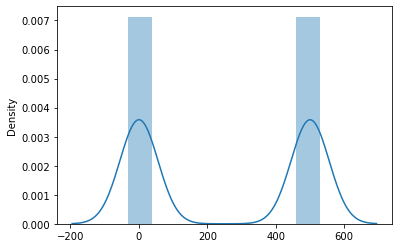

In [7]:
# Data
sigma = DIST_STD_DEV # mean and standard deviation
node_data = [np.array(x) for dist in 
    [np.random.multivariate_normal(clusters[i], [[sigma, 0], [0, sigma]], int(NUM_NODES/NUM_CLUSTERS)) for i in range(NUM_CLUSTERS)] 
        for x in dist]
_ = sns.distplot(node_data)

In [8]:
# Tangle Initialization
tx_store = TempTransactionStore()
genesis = Transaction([])
genesis.add_metadata('time', 0)
# Initialize the genesis transaction with a number within the std dev interval
# tx_store.save(genesis, np.array([random.uniform(-DIST_STD_DEV, DIST_STD_DEV), random.uniform(-DIST_STD_DEV, DIST_STD_DEV)]))
tx_store.save(genesis, np.array([250, 250]))
tangle = Tangle({genesis.id: genesis}, genesis.id)

In [9]:
# Results
num_txs = []     # Number of published transactions per round
consensus_per_cluster = [[] for _ in range(NUM_CLUSTERS)]   # Value of consensus transaction per round 
consensus_txs_per_cluster = [[] for _ in range(NUM_CLUSTERS)]   # Value of consensus transaction per round

In [10]:
for r in tqdm(range(NUM_ROUNDS)):
    txs = []

    for _ in range(NODES_PER_ROUND):
        node_id = np.random.randint(NUM_NODES)
        tip_selector = AccuracyTipSelector(tangle, tip_selection_settings)
        cluster_id = int(node_id/(NUM_NODES/NUM_CLUSTERS))
        node = TheoreticalNode(tangle, tx_store, tip_selector, str(node_id), cluster_id, node_data[node_id])
        tx, tx_weights = node.create_transaction()

        if tx is not None:
            tx.add_metadata('time', r+1)
            tx.add_metadata('issuer', node_id)
            tx_store.save(tx, tx_weights)
            txs.append(tx)

    for tx in txs:
        tangle.add_transaction(tx)

    reference_values_per_cluster = [[] for _ in range(NUM_CLUSTERS)]
    reference_txs_per_cluster = [[] for _ in range(NUM_CLUSTERS)]
    tip_selector_per_cluster = [AccuracyTipSelector(tangle, tip_selection_settings) for _ in range(NUM_CLUSTERS)]
    validation_node_per_cluster = [TheoreticalNode(tangle, tx_store, tip_selector_per_cluster[i], 0, None, clusters[i]) for i in range(NUM_CLUSTERS)]
    for i in range(NUM_CLUSTERS):
        for _ in range(int(VALIDATIONS_PER_ROUND)):
            reference_tx, reference = validation_node_per_cluster[i].obtain_reference_params()
            reference_values_per_cluster[i].append(reference)
            reference_txs_per_cluster[i].append(reference_tx)

        consensus_per_cluster[i].append(reference_values_per_cluster[i])
        consensus_txs_per_cluster[i].append(reference_txs_per_cluster[i])

    num_txs.append(len(txs))

100%|██████████| 50/50 [01:57<00:00,  2.34s/it]


**Transactions per round**

<AxesSubplot:>

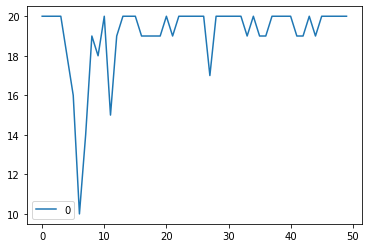

In [11]:
sns.lineplot(data=pd.DataFrame(num_txs))

**Consensus cluster 0 (-250)**

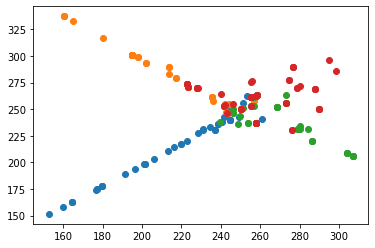

In [12]:
ax = plt.axes()

for i in range(NUM_CLUSTERS):
    test = [np.median(consensus_per_cluster[i][j], axis=0) for j in range(NUM_ROUNDS)]
    ax.scatter([x[0] for x in test], [x[1] for x in test])

**Last consensus, minimum delta to optimum**

In [13]:
from tangle.lab import LabTransactionStore
tx_store = LabTransactionStore('.')
tx_store.save_tangle(tangle, 'walk_many')

In [ ]:
[median(consensus_per_cluster[i]), min([np.linalg.norm(median(x)-clusters[i])) for i in range(NUM_CLUSTERS) for x in consensus_per_cluster[i]]

In [ ]:
median(consensus_c1[-1]), min([abs(median(x)-CLUSTER_DISTANCE/2) for x in consensus_c1])

**Consensus round cluster 0**

In [ ]:
rounds = pd.DataFrame([median([tangle.transactions[x[0]].metadata['time'] for x in txs]) for txs in consensus_txs_c0])
sns.lineplot(data=rounds)